In [14]:
import sys
import os
sys.path.append(os.path.abspath("D:\\Python\\commodity_futures_price"))

import math

import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from model.savvy_sh import SavvySh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
path = "../../data/investing.com/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LB due to data correctness issue
        if file.startswith(("LB", "JN", "LL", "LN", "LT", "LX")):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True, thousands=",")
        df = df.iloc[:, 0:1].astype(float)
        if (df <= 0).any().any():
            print(f"Non-positive values found in {file[:-4]}")
        df = df[df > 0]

        # reverse the rows
        df = df.iloc[::-1]
        # drop the first row and last 2 rows to match cc1 data
        df = df.iloc[0:-4]

        print(file[:-4], df.shape)

BO (155, 1)
CC (155, 1)
CL (155, 1)
CO (155, 1)
CT (150, 1)
C_ (155, 1)
DA (150, 1)
FC (155, 1)
GC (155, 1)
HG (155, 1)
HO (155, 1)
JO (155, 1)
KC (155, 1)
LA (120, 1)
LC (155, 1)
LH (155, 1)
NG (155, 1)
O_ (155, 1)
PA (155, 1)
PL (155, 1)
QS (155, 1)
RR (155, 1)
RS (155, 1)
SB (155, 1)
SI (155, 1)
SM (155, 1)
S_ (155, 1)
W_ (155, 1)
XB (149, 1)


CT, DA could only find data starting from 2011/12/01  
LA from 2014/06/01  
XB from 2012/01/01  
Therefore, we take all of the data starting from 2011/12/01, and exclude LA and XB.

In [16]:
df_dict_cc1 = {}
valid_dates = pd.date_range(start="2011-01-01", end="2024-12-31", freq="B")
# Read each file in below folder
path = "../../data/raw/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LA, LB, JN, LL, LN, LT, LX, XB due to data correctness issue
        if file.startswith(("LA", "LB", "JN", "LL", "LN", "LT", "LX", "XB")):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True)

        # Drop non-positive values in price and volatility
        non_positive_LA = df[(df[df.columns[0]] <= 0) | (df['Volatility'] <= 0)]
        if not non_positive_LA.empty:
            print(f"Non-positive values found in {file[:-4]}")
        df = df.drop(index=non_positive_LA.index)

        df_dict_cc1[file[:-4]] = df
        valid_dates = valid_dates.intersection(df.index)

for name, df in df_dict_cc1.items():
    df = df[df.index.isin(valid_dates)].loc["2011-12-30":"2024-05-31"]
    df_dict_cc1[name] = df

In [17]:
df_dict_cc2 = {}
# Read each file in below folder
path = "../../data/investing.com/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LB due to data correctness issue
        if file.startswith(("LA", "LB", "JN", "LL", "LN", "LT", "LX", "XB")):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True, thousands=",")
        df = df.iloc[:, 0:1].astype(float)
        if (df <= 0).any().any():
            print(f"Non-positive values found in {file[:-4]}")
        df = df[df > 0]

        # reverse the rows
        df = df.iloc[::-1]
        # take data during 2012-01-01 to 2024-06-01 only
        df = df.loc["2012-01-01":"2024-06-01"]

        # HG, HO
        if file.startswith(("HG", "HO")):
            df = df * 100
        # save the data
        df.to_csv(f"../../data/processed/{file[:-4]}.csv")

        df_dict_cc2[file[:-4]] = df

### Calculate the Return for Holding CC2 for one month

Assuming expired at the mid of each month below

In [18]:
expiration_months = {
    "BO": [1, 3, 5, 7, 8, 9, 10, 12],   # Soybean Oil
    "CC": [3, 5, 7, 9, 12],             # Cocoa
    "CL": list(range(1, 13)),           # WTI Crude Oil (every month)
    "CO": list(range(1, 13)),           # Brent (every month)
    "CT": [3, 5, 7, 10, 12],            # Cotton
    "C_": [3, 5, 7, 9, 12],             # Corn
    "DA": list(range(1, 13)),           # Class III Milk
    "FC": [1, 3, 5, 8, 9, 11],          # Feeder Cattle
    "GC": [2, 4, 6, 8, 10, 12],         # Gold
    "HG": [3, 5, 7, 9, 12],             # Copper
    "HO": list(range(1, 13)),           # Heating Oil
    "JO": [1, 3, 5, 7, 9, 12],          # Orange Juice
    "KC": [3, 5, 7, 9, 12],             # Coffee
    "LC": [2, 4, 6, 8, 10, 12],         # Live Cattle
    "LH": [2, 4, 6, 8, 10, 12],         # Lean Hogs
    "NG": list(range(1, 13)),           # Nat Gas
    "O_": [3, 5, 7, 9, 12],             # Oats
    "PA": [3, 6, 9, 12],                # Palladium
    "PL": [1, 4, 7, 10],                # Platinum
    "QS": list(range(1, 13)),           # Other metals (London) every month
    "RR": [1, 3, 5, 7, 9, 11],          # Rough Rice
    "RS": [1, 3, 5, 7, 11],             # Canola
    "SB": [3, 5, 7, 10],                # Sugar
    "SI": [3, 5, 7, 9, 12],             # Silver
    "SM": [1, 3, 5, 7, 8, 9, 10, 12],   # Soybean Meal
    "S_": [1, 3, 5, 7, 8, 9, 11],       # Soybeans
    "W_": [3, 5, 7, 9, 12],             # Wheat
}

**The logic below is**:  
if we bought BO cc2 at 1/1, it should be expired at 3/15, and since after 1/15, this contract become cc1. So the numerator of return of saling this contract after one month should be the price of cc1.  
On the other hand, if we bought at 2/1, since there is not any contract expired after one month, the contract would still be cc2. Thus, the numerator should be the price of cc2.  
Note that we have shift the numerator at the first.

In [19]:
for name, df in df_dict_cc1.items():
    numerator = df.iloc[:, 0:1].shift(-1)[:-1]
    denominator = df_dict_cc2[name].iloc[:, 0:1]
    if name in ["CL", "CO", "DA", "HO", "NG", "QS"]:
        df["Return"] = np.append(np.log(numerator.values / denominator.iloc[:-1].values), np.nan)
    else:
        exp_month = expiration_months[name]
        for i in range(len(denominator) - 1):
            if denominator.index[i].month in exp_month:
                df.loc[df.index[i], "Return"] = np.log(numerator.values[i] / denominator.values[i])
            else:
                df.loc[df.index[i], "Return"] = np.log(denominator.values[i + 1] / denominator.values[i])

In [20]:
dates_len = df_dict_cc1["BO"].shape[0]
train_size = 3 * 12
test_size = 1

start_end_list = []
start = 0
while(start < dates_len - train_size - test_size):
    end = start + train_size + test_size - 1
    start_end_list.append((start, end))
    start = start + test_size

# print(start_end_list)

### Regression and Prediction

### OLS

In [21]:
ols_mse_by_time = []
ols_hit_ratio_by_time = []
for start, end in start_end_list:
    ols_mse_by_df = []
    ols_hit_ratio_by_df = []
    for name, df in df_dict_cc1.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test_X, test_y = df.iloc[end - test_size + 1:end - test_size + 2].drop(columns=["Basis_Momentum", "Return"]), df.iloc[end - test_size + 1:end - test_size + 2]["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        ols = LinearRegression()
        ols.fit(train_X, train_y)
        ols_predict = ols.predict(test_X)

        ols_mse = mean_squared_error(test_y, ols_predict)
        ols_mse_by_df.append(ols_mse)

        # MSE / Variance (y)
        # var_y = np.var(train_y, ddof=1)
        # print(ols_mse / var_y)

        # Hit Ratio
        ols_hit_ratio_by_df.append((ols_predict > 0) == (test_y > 0))

    ols_mse_by_time.append(np.mean(ols_mse_by_df))
    ols_hit_ratio_by_time.append(np.mean(ols_hit_ratio_by_df))

# print(np.mean(ols_hit_ratio_by_time))

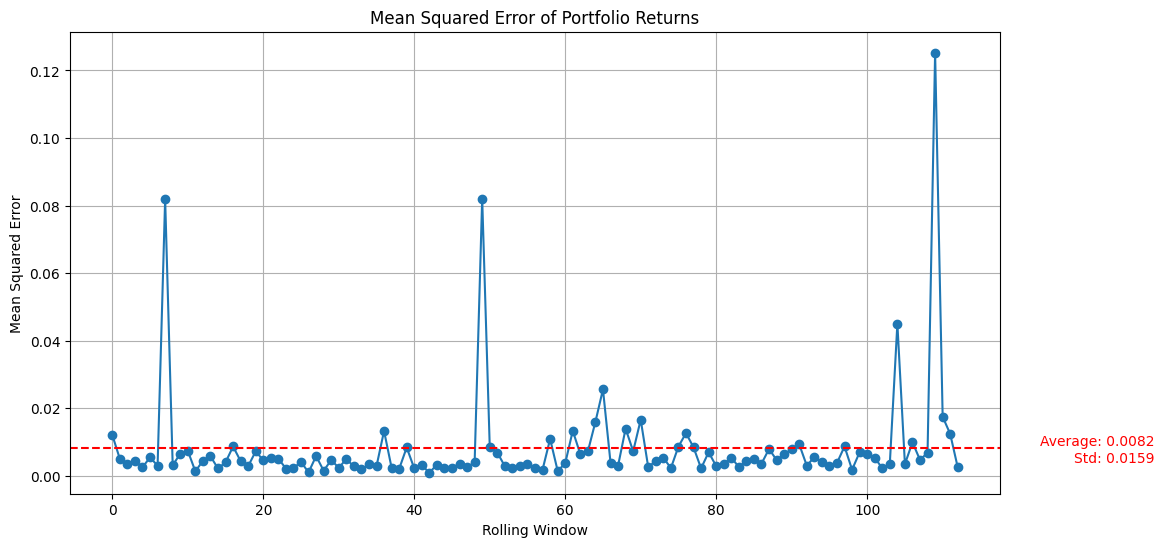

In [22]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(ols_mse_by_time, marker='o')
plt.axhline(y=np.mean(ols_mse_by_time), color='r', linestyle='--')
plt.text(len(ols_mse_by_time) + 25, np.mean(ols_mse_by_time), f"Average: {np.mean(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(ols_mse_by_time) + 25, np.mean(ols_mse_by_time) - 0.005, f"Std: {np.std(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Stein

In [23]:
stein_mse_by_time = []
stein_hit_ratio_by_time = []
for start, end in start_end_list:
    stein_mse_by_df = []
    stein_hit_ratio_by_df = []
    for name, df in df_dict_cc1.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test_X, test_y = df.iloc[end - test_size + 1:end - test_size + 2].drop(columns=["Basis_Momentum", "Return"]), df.iloc[end - test_size + 1:end - test_size + 2]["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        model_mult = SavvySh(model_class="Multiplicative")
        model_mult.fit(train_X, train_y)
        stein_predict = model_mult.predict(test_X)["St"]

        stein_mse = mean_squared_error(test_y, stein_predict)
        stein_mse_by_df.append(stein_mse)
        
        # var_y = np.var(train_y, ddof=1)
        # print(stein_mse / var_y)

        # Hit Ratio
        stein_hit_ratio_by_df.append((stein_predict > 0) == (test_y > 0))

    stein_mse_by_time.append(np.mean(stein_mse_by_df))
    stein_hit_ratio_by_time.append(np.mean(stein_hit_ratio_by_df))

# print(np.mean(stein_hit_ratio_by_time))

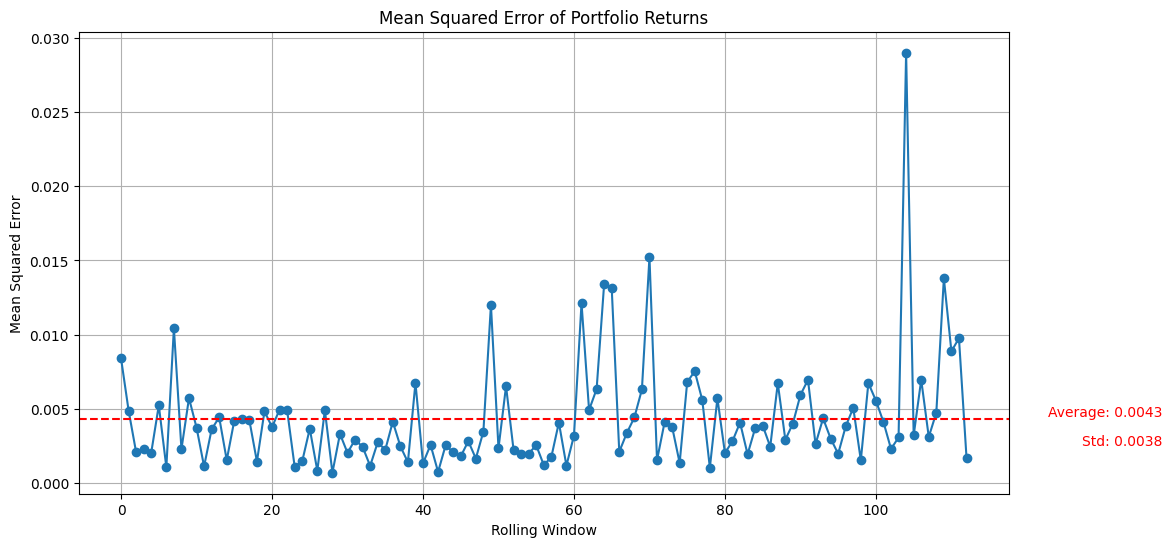

In [24]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(stein_mse_by_time, marker='o')
plt.axhline(y=np.mean(stein_mse_by_time), color='r', linestyle='--')
plt.text(len(stein_mse_by_time) + 25, np.mean(stein_mse_by_time), f"Average: {np.mean(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(stein_mse_by_time) + 25, np.mean(stein_mse_by_time) - 0.002, f"Std: {np.std(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### DSh

In [25]:
DSh_mse_by_time = []
DSh_hit_ratio_by_time = []
for start, end in start_end_list:
    DSh_mse_by_df = []
    DSh_hit_ratio_by_df = []
    for name, df in df_dict_cc1.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test = df.iloc[end - test_size + 1:end - test_size + 2]
        test_X, test_y = test.drop(columns=["Basis_Momentum", "Return"]), test["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        model_mult = SavvySh(model_class="Multiplicative")
        model_mult.fit(train_X, train_y)
        DSh_predict = model_mult.predict(test_X)["DSh"]

        DSh_mse = mean_squared_error(test_y, DSh_predict)
        DSh_mse_by_df.append(DSh_mse)

        # var_y = np.var(train_y, ddof=1)
        # print(DSh_mse / var_y)

        # Hit Ratio
        DSh_hit_ratio_by_df.append((DSh_predict > 0) == (test_y > 0))

    DSh_mse_by_time.append(np.mean(DSh_mse_by_df))
    DSh_hit_ratio_by_time.append(np.mean(DSh_hit_ratio_by_df))

# print(np.mean(DSh_hit_ratio_by_time))

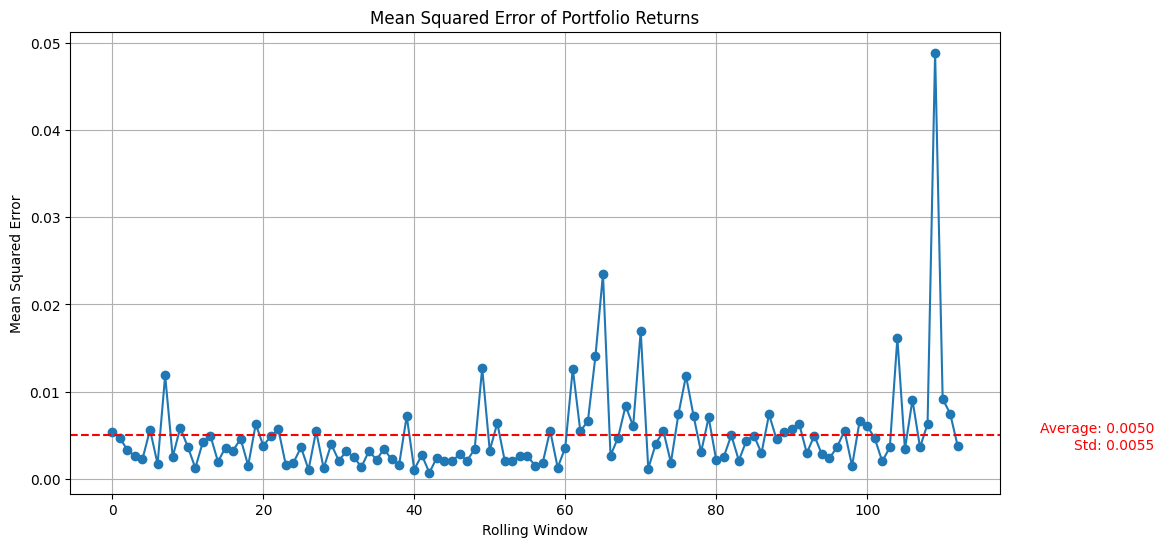

In [26]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(DSh_mse_by_time, marker='o')
plt.axhline(y=np.mean(DSh_mse_by_time), color='r', linestyle='--')
plt.text(len(DSh_mse_by_time) + 25, np.mean(DSh_mse_by_time), f"Average: {np.mean(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(DSh_mse_by_time) + 25, np.mean(DSh_mse_by_time) - 0.002, f"Std: {np.std(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Portfolio weighted by returns

In [27]:
threshold = 0.005
indexs = df_dict_cc1["BO"].index

In [111]:
# Initialize
strategies = ["OLS", "St", "DSh", "Sh", "SR", "GSR", "LSh", "SRR"]
weights_dict = {}
wealth_dict = {}
initial_capital = 10000
returns_dict = {strat: [] for strat in strategies}

coef_dict = {strat: {name: [] for name in df_dict_cc1.keys()} for strat in strategies}

for strat in strategies:
    weights_dict[strat] = pd.DataFrame(columns=list(df_dict_cc1.keys()), index=pd.Index([], name="Time"))
    wealth_dict[strat] = [initial_capital]

# Main loop
for start, end in start_end_list:
    for strat in strategies:
        temp_long_return = 0
        temp_short_return = 0
        long_weights = 0
        short_weights = 0

        temp_weights = pd.Series(0.0, index=list(df_dict_cc1.keys()))

        for name, df in df_dict_cc1.items():
            train = df.iloc[start:end - test_size + 1, 1:]
            train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
            next_index = end - test_size + 1
            if next_index + 1 >= len(df):
                continue
            test_X = df.iloc[[next_index], 1:].drop(columns=["Basis_Momentum", "Return"])

            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X)
            test_X = scaler.transform(test_X)

            # Prediction
            if strat == "OLS":
                ols = LinearRegression()
                ols.fit(train_X, train_y)
                coef_dict[strat][name].append(np.concatenate(([ols.intercept_], ols.coef_)))
                predict = ols.predict(test_X).flatten()
            elif strat == "LSh":
                model_linear = SavvySh(model_class="Linear")
                model_linear.fit(train_X, train_y)
                coef_dict[strat][name].append(np.concatenate(([model_linear.intercept_[strat]], model_linear.coef_[strat])))

                predict = model_linear.predict(test_X)["LSh"]
            elif strat == "SRR":
                model_shrinkage_ridge = SavvySh(model_class="ShrinkageRR")
                model_shrinkage_ridge.fit(train_X, train_y)
                coef_dict[strat][name].append(np.concatenate(([model_shrinkage_ridge.intercept_[strat]], model_shrinkage_ridge.coef_[strat])))
                predict = model_shrinkage_ridge.predict(test_X)["SRR"]
            elif strat in ["SR", "GSR"]:
                model_slab = SavvySh(model_class="Slab")
                model_slab.fit(train_X, train_y)
                coef_dict[strat][name].append(np.concatenate(([model_slab.intercept_[strat]], model_slab.coef_[strat])))
                tmp_pred = model_slab.predict(test_X)
                if strat == "SR":
                    predict = tmp_pred["SR"]
                else:
                    predict = tmp_pred["GSR"]
            else:
                model_mult = SavvySh(model_class="Multiplicative", include_Sh=True)
                model_mult.fit(train_X, train_y)
                coef_dict[strat][name].append(np.concatenate(([model_mult.intercept_[strat]], model_mult.coef_[strat])))
                tmp_pred = model_mult.predict(test_X)
                if strat == "Stein":
                    predict = tmp_pred["St"]
                elif strat == "DSh":
                    predict = tmp_pred["DSh"]
                else:
                    predict = tmp_pred["Sh"]
            predict = predict[0]
            ret = (math.exp(df_dict_cc1[name].iloc[next_index]["Return"]))
            
            if predict > threshold:
                long_weights += predict
                temp_long_return += predict * (ret - 1)
                temp_weights[name] = predict
            elif predict < -threshold:
                short_weights -= predict  # Take negative as weights
                temp_short_return += -predict * (1 - ret)
                temp_weights[name] = predict

        # Normalize weights to avoid division by zero
        if long_weights > 0:
            temp_weights[temp_weights > 0] = 0.5 * temp_weights[temp_weights > 0] / long_weights
        if short_weights > 0:
            temp_weights[temp_weights < 0] = 0.5 * (-temp_weights[temp_weights < 0]) / short_weights * -1
        weights_dict[strat].loc[indexs[next_index]] = temp_weights

        # Calculate portfolio return
        portfolio_return = 0
        if long_weights > 0:
            portfolio_return += 0.5 * temp_long_return / long_weights
        if short_weights > 0:
            portfolio_return += 0.5 * temp_short_return / short_weights

        # Update wealth
        wealth_dict[strat].append(wealth_dict[strat][-1] * (1 + portfolio_return))
        returns_dict[strat].append(portfolio_return)

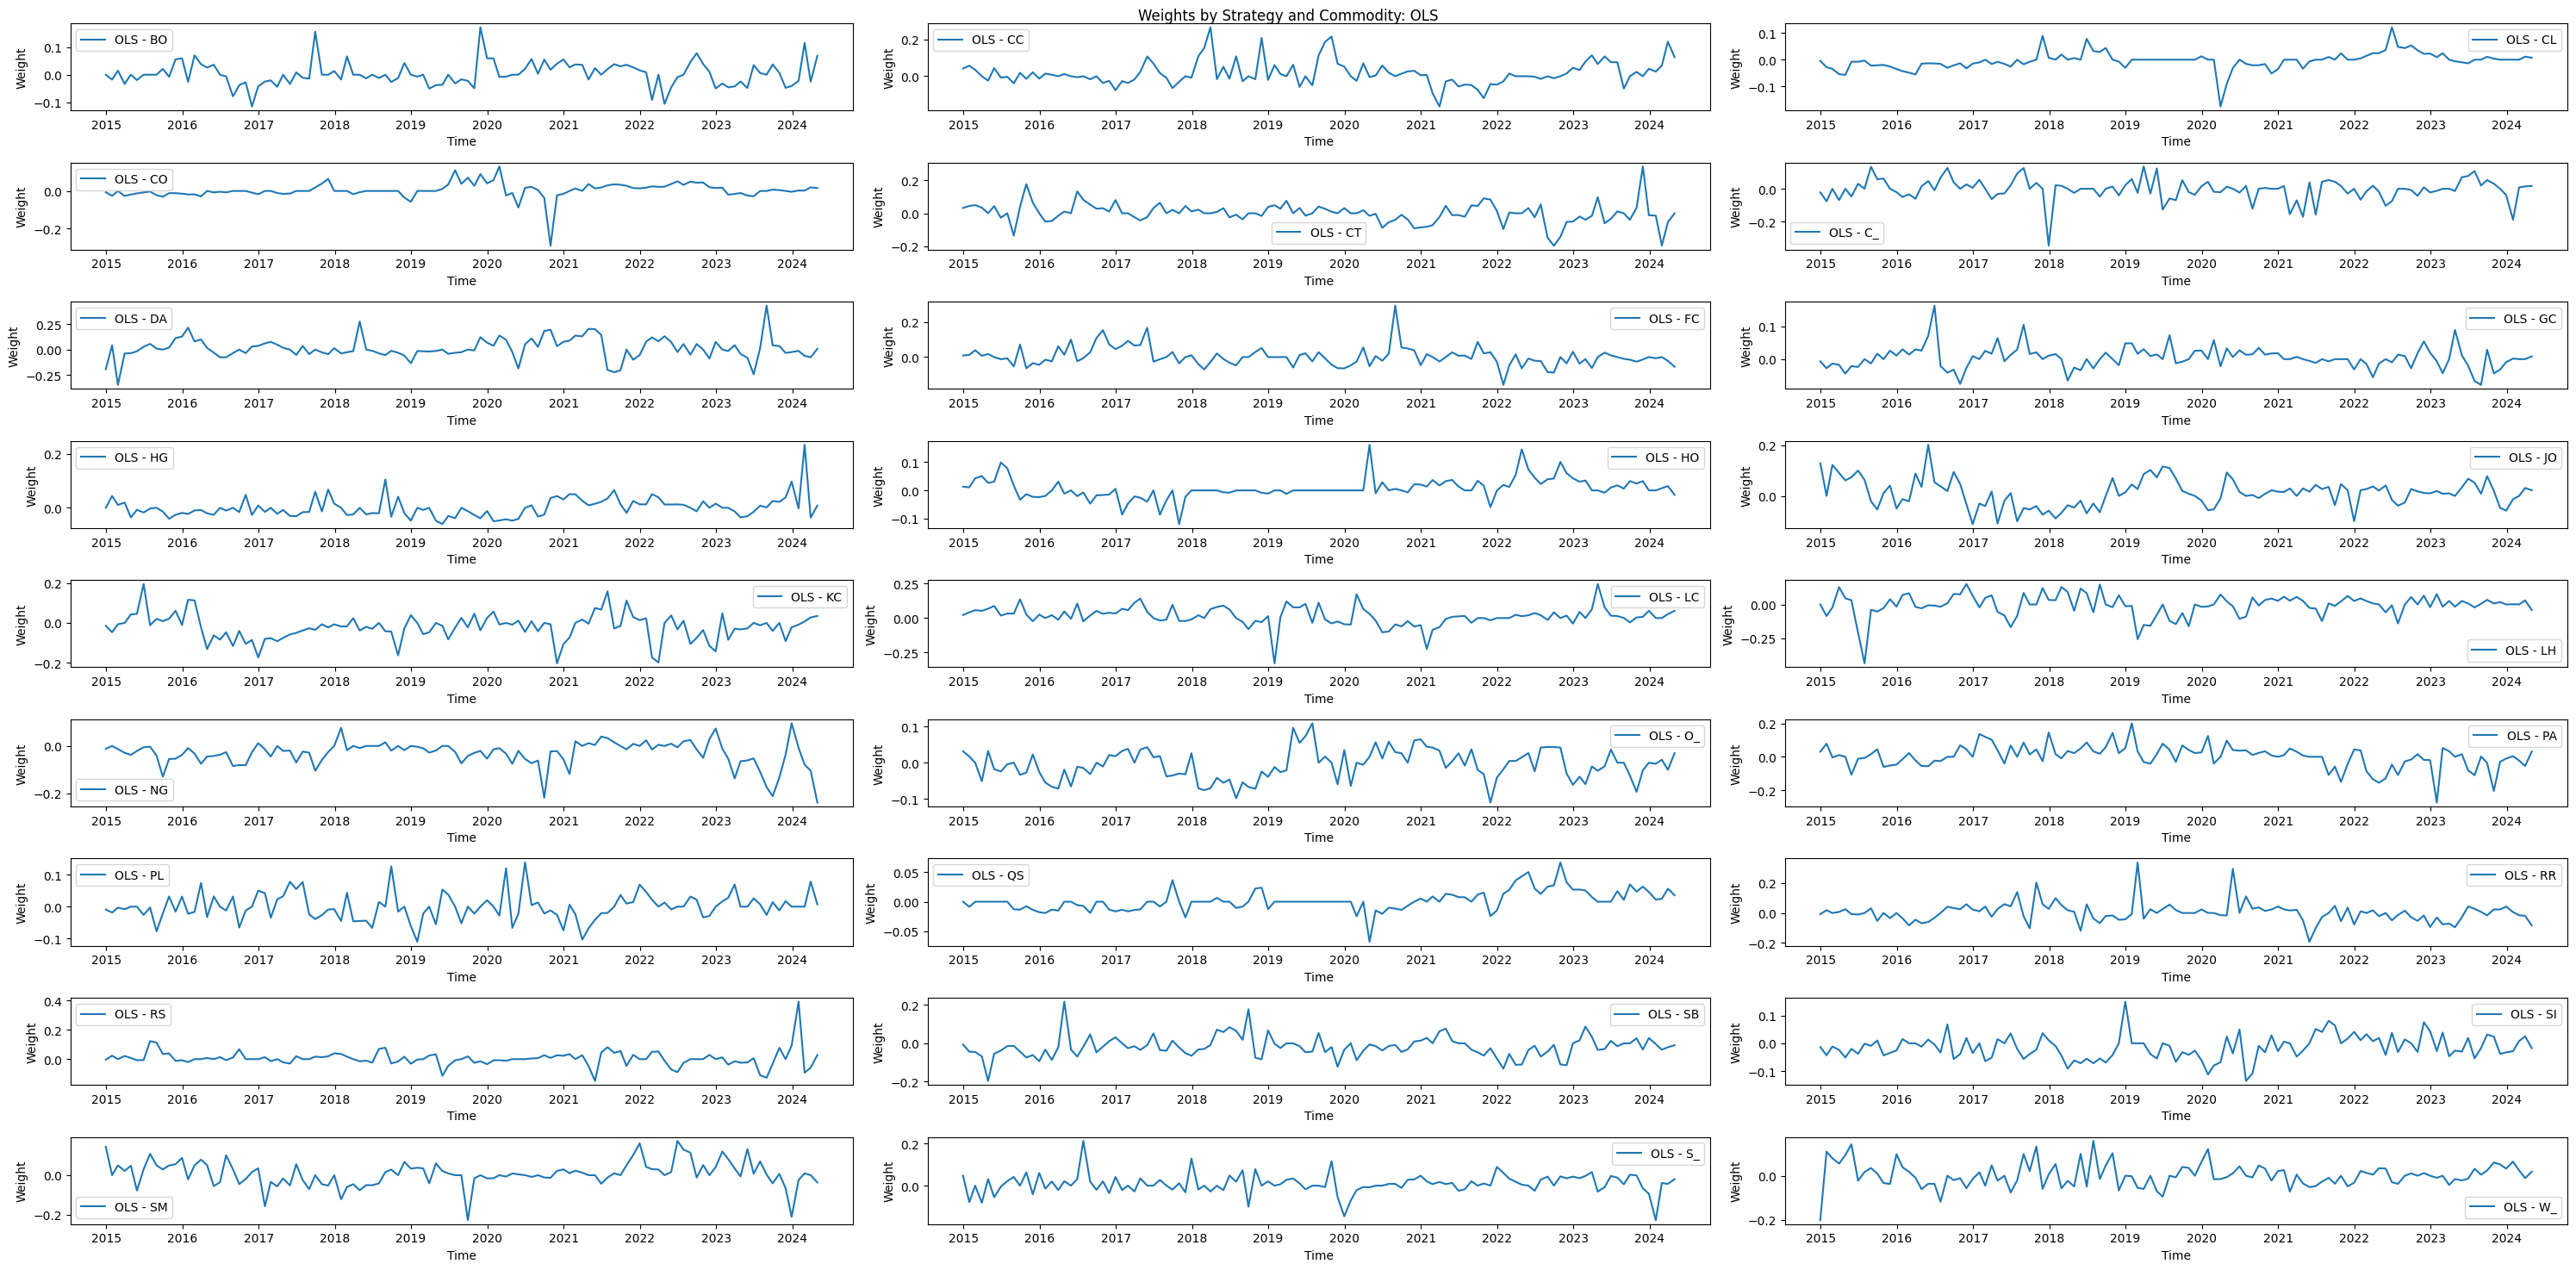

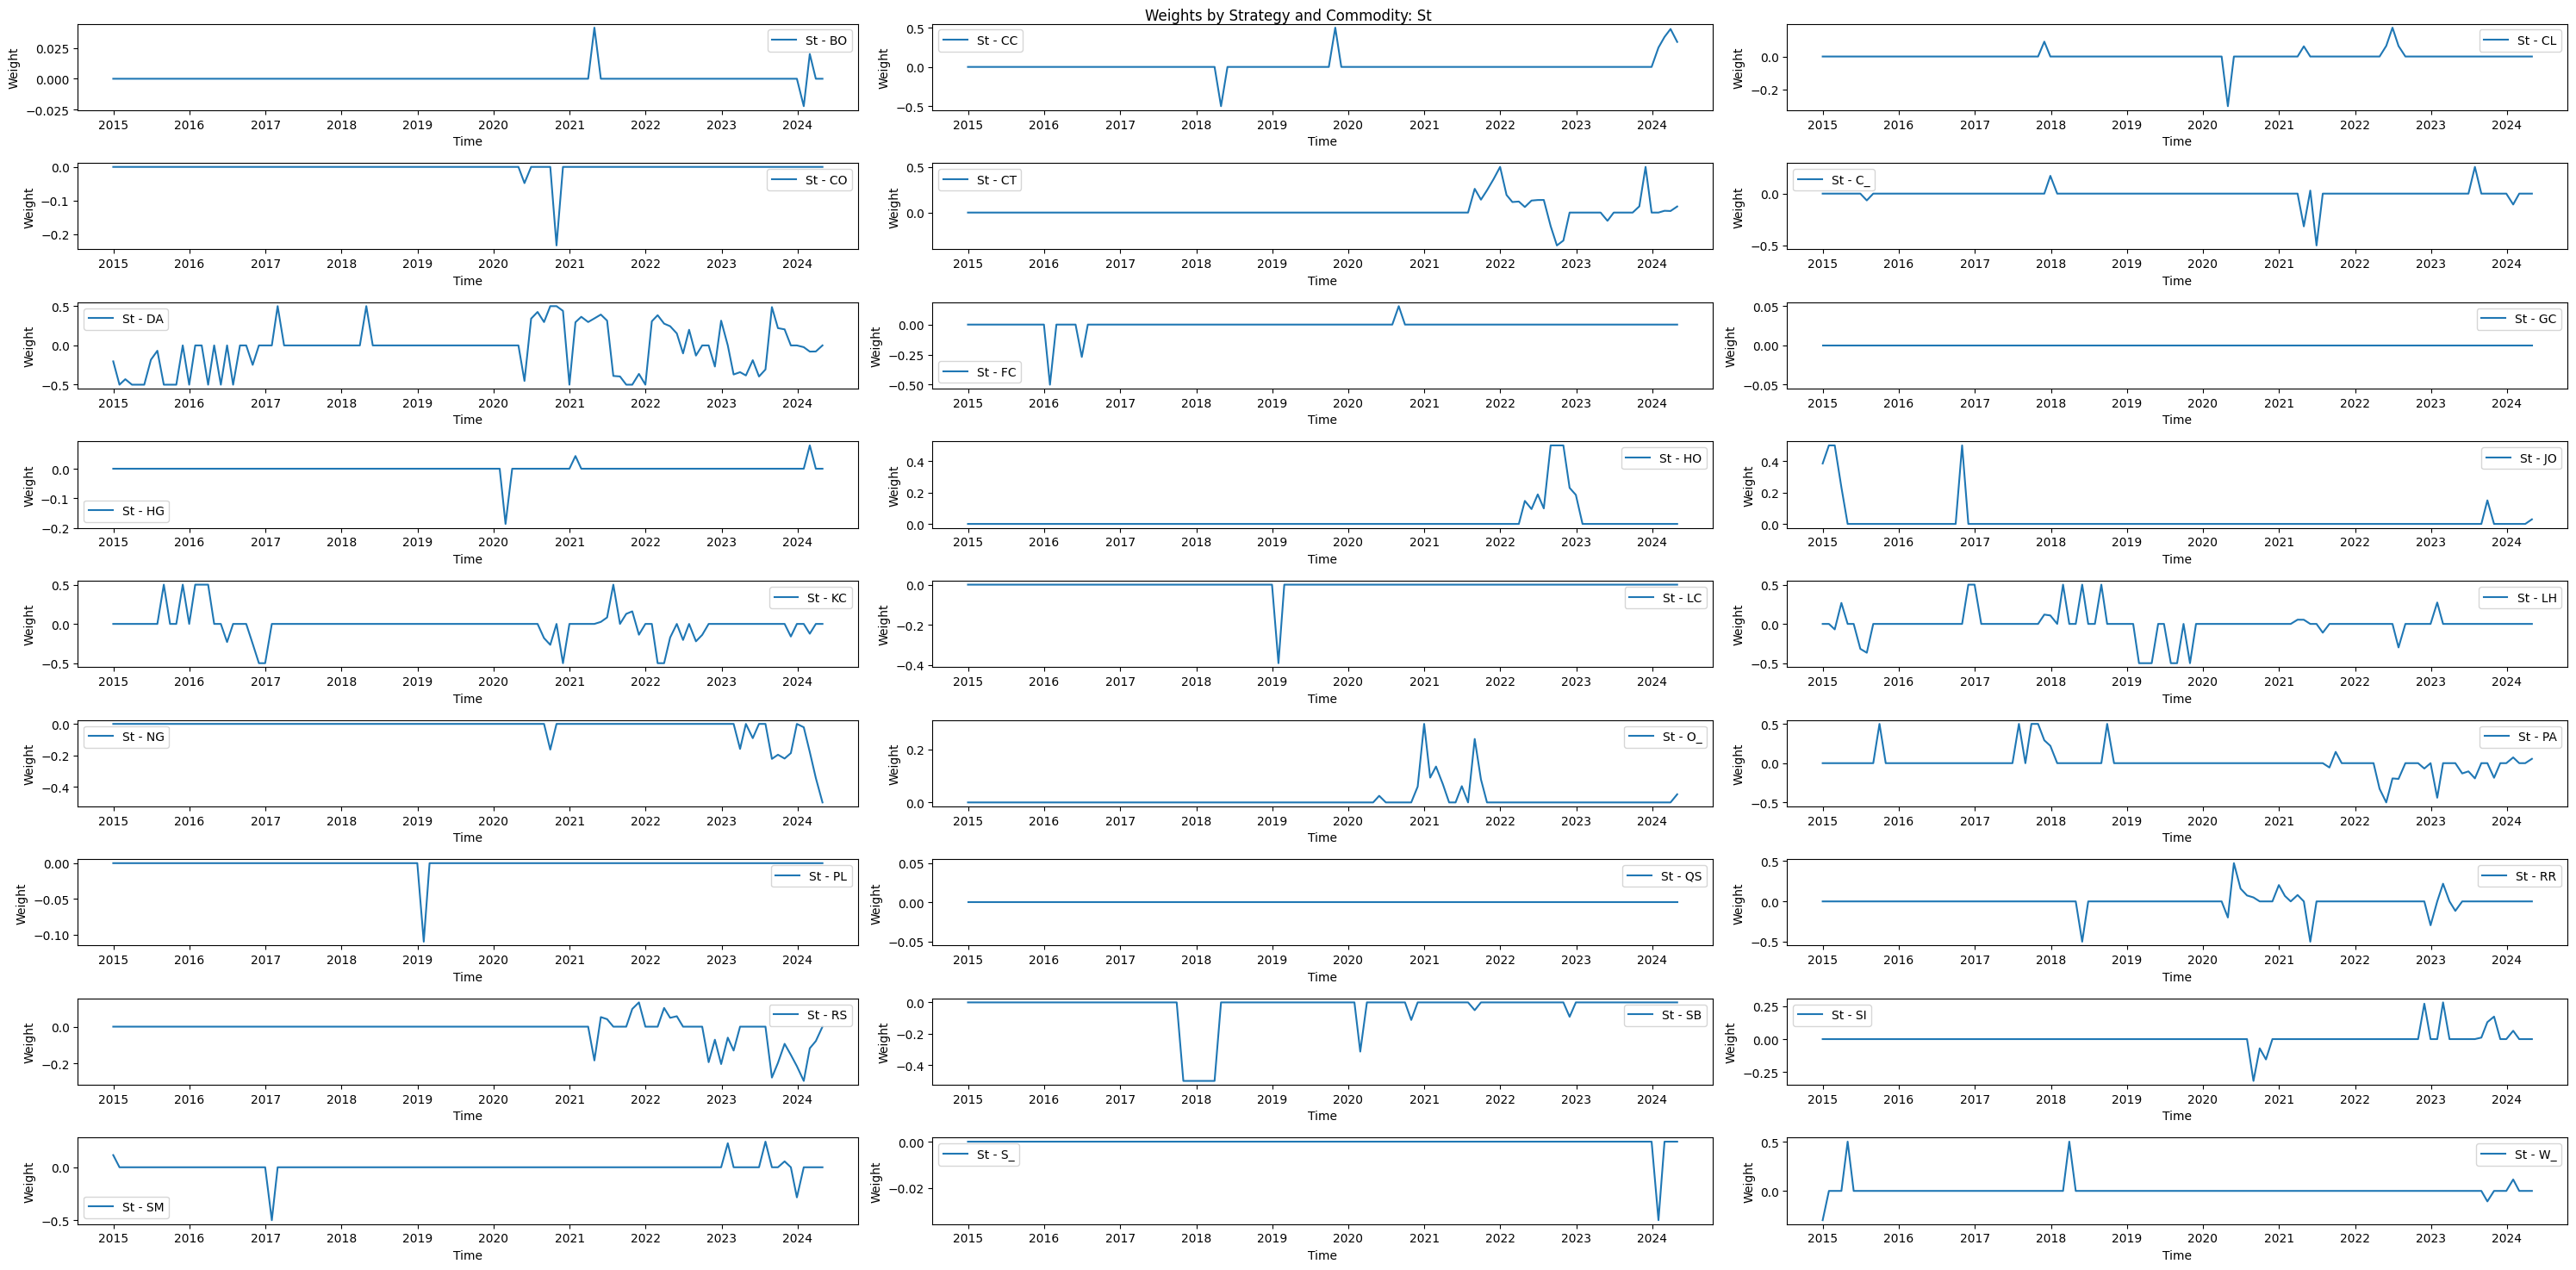

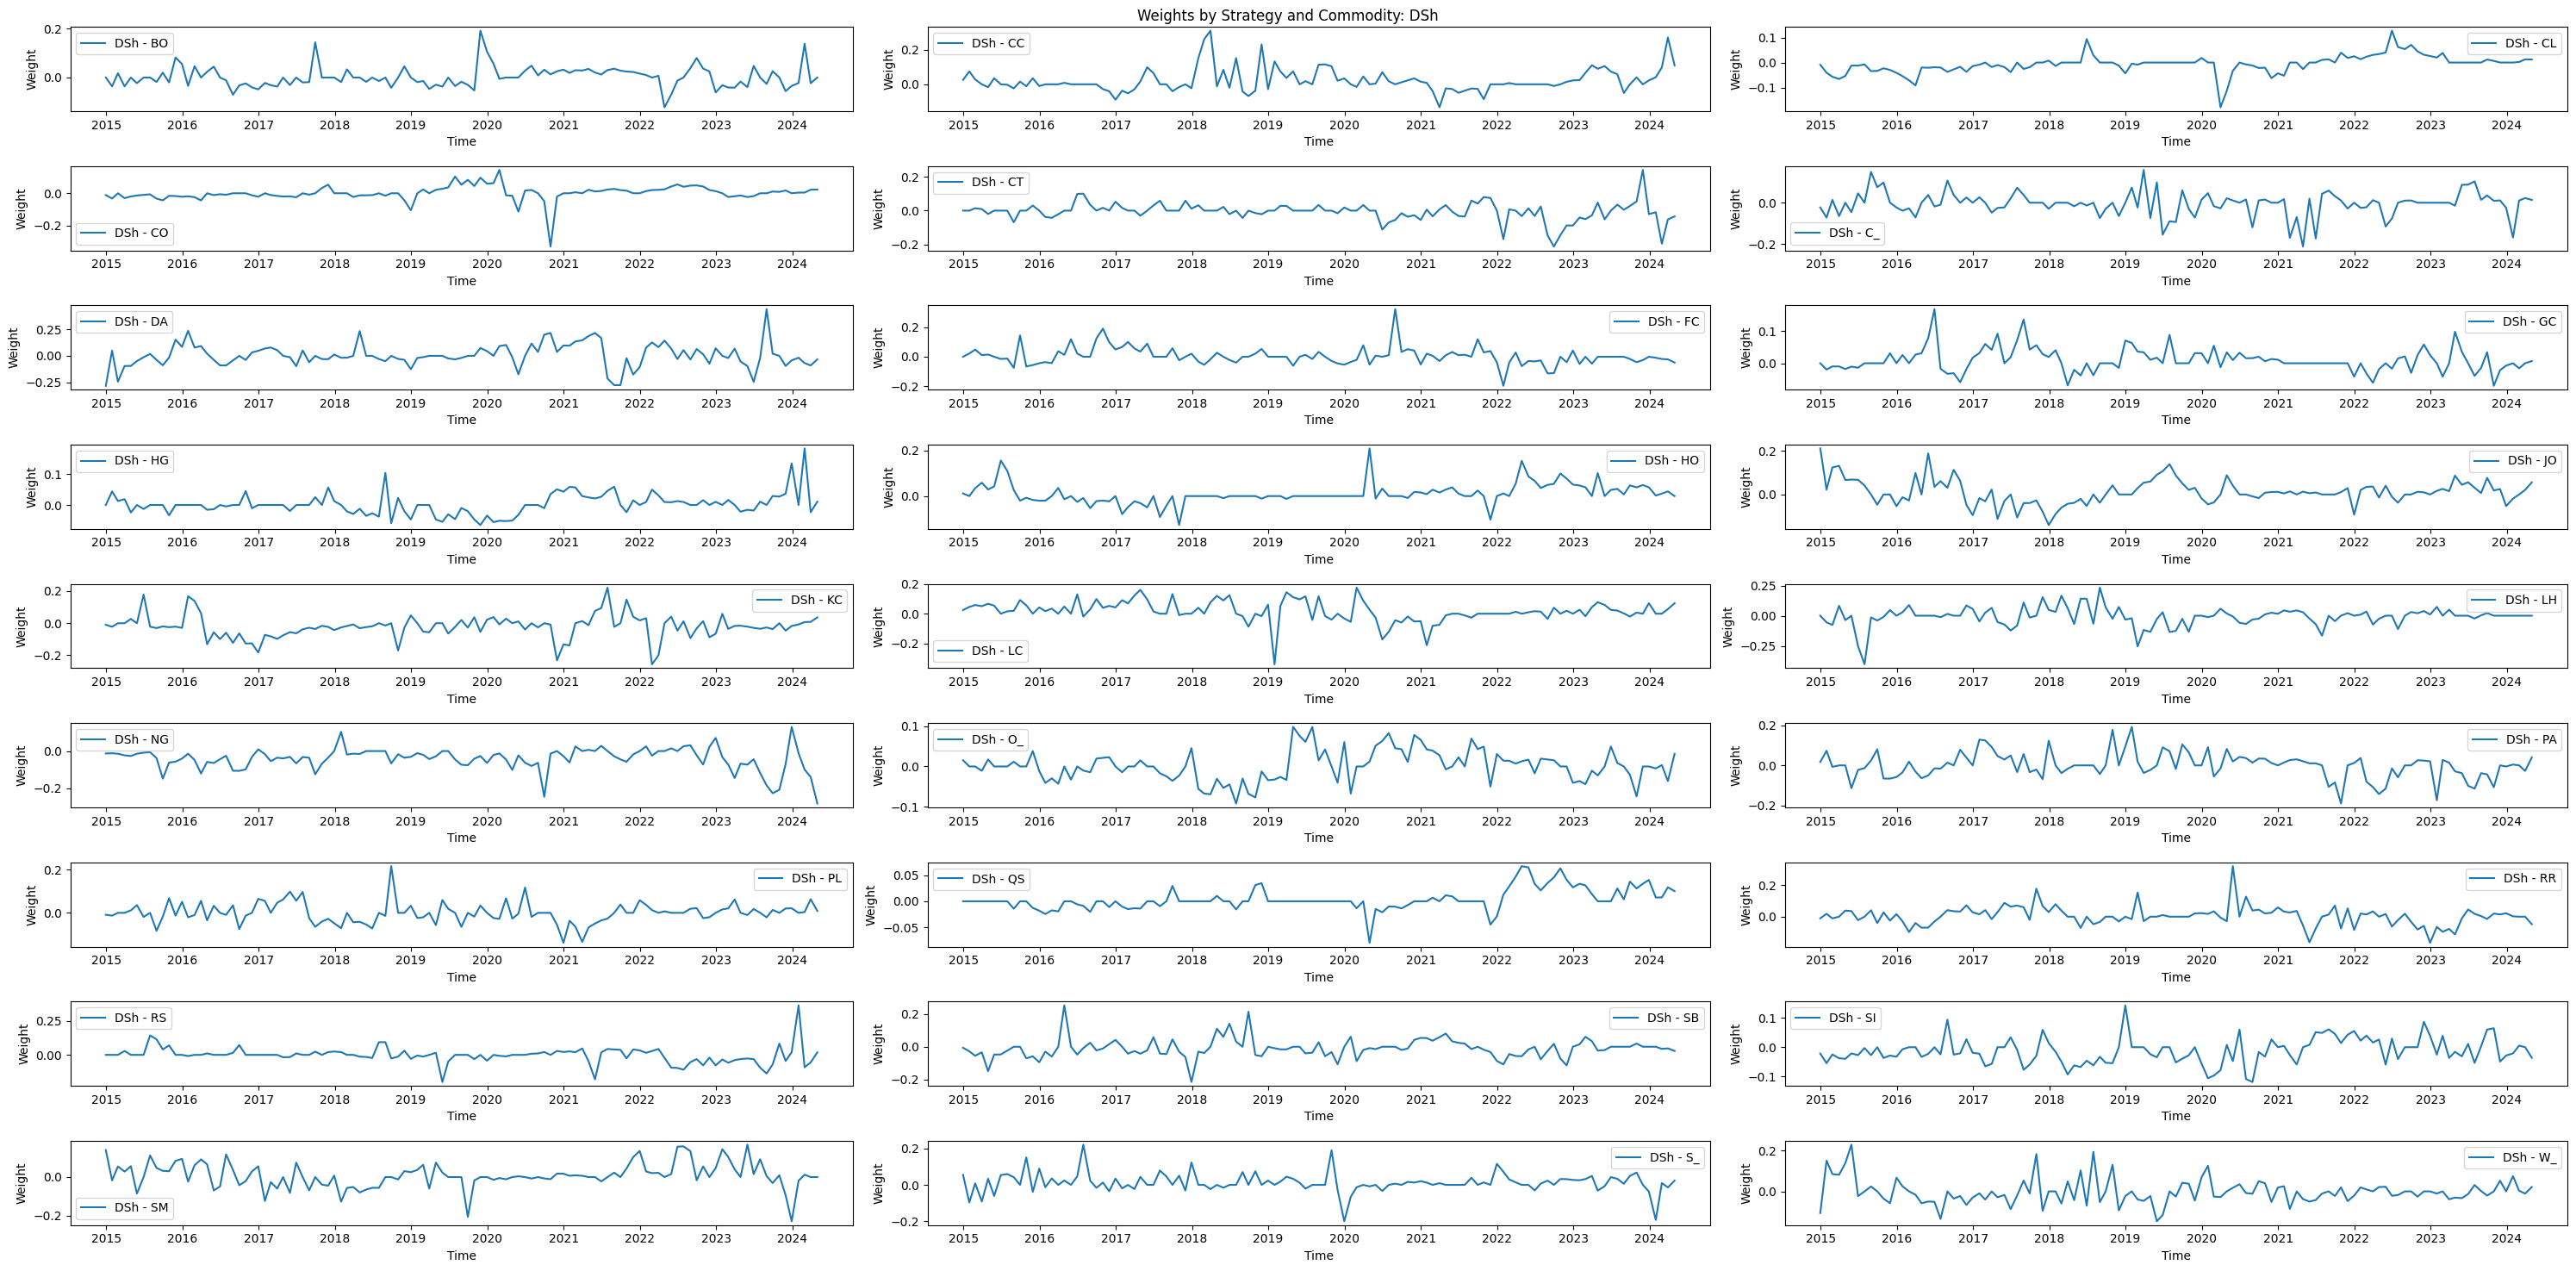

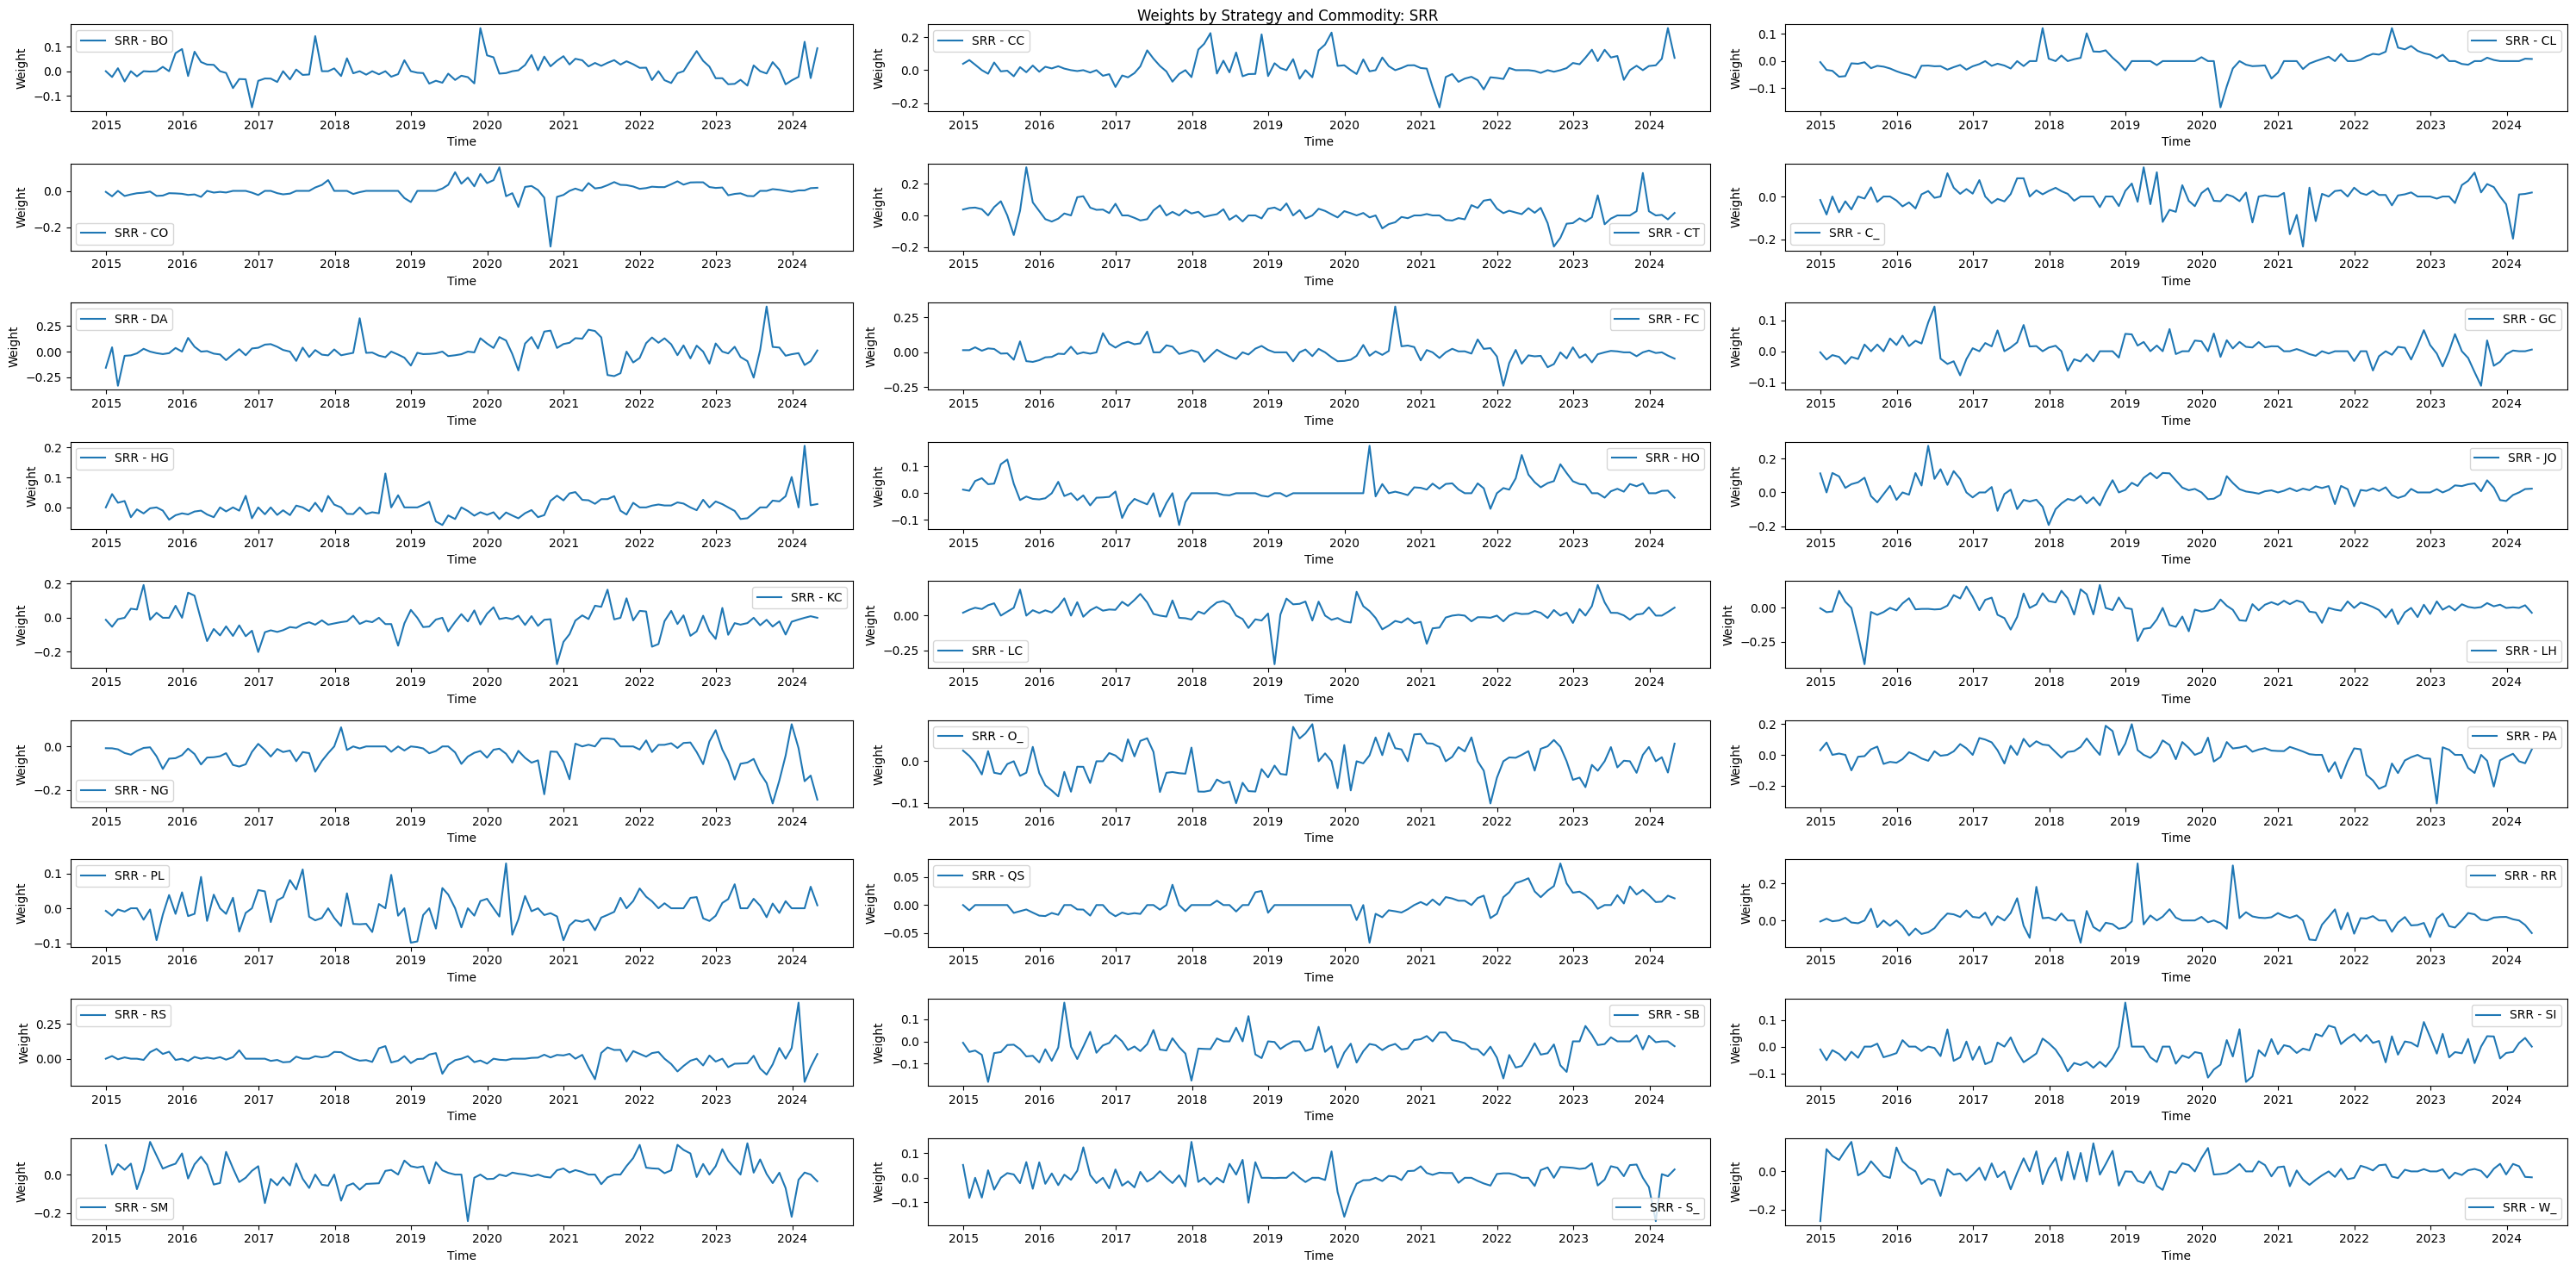

In [106]:
comms = weights_dict["OLS"].columns
for strat in sub_strat:
    n = len(comms)
    n_cols = 3
    n_rows = math.ceil(n / n_cols)
    plt.figure(figsize=(30, 15))
    plt.suptitle(f"Weights by Strategy and Commodity: {strat}")
    for comm in comms:
        plt.subplot(n_rows, n_cols, comms.get_loc(comm) + 1)
        plt.plot(weights_dict[strat][comm], label=f"{strat} - {comm}")
        plt.xlabel("Time")
        plt.ylabel("Weight")
        plt.legend()
    plt.tight_layout()
    plt.show()

- Obsrv 1: Stein estimator shrinkage the prediction to 0 by absolute value, thus causing most signal smaller than the threshold and thus be eliminated.
- Obsrv 2: For models other than Stein, two commodities' weight stay around 0 for most of the time, and be positive some times while rarely negative, which are HG, RS. On the other hand, some are also around 0 and negative but rarely positive, including CO, C_, NG, SM.
- Obsrv 3: While SRR makes weights of most of the commodities become more symmetric of 0, HG and RS are still tend to be positive, which might indicates that these two commodities are "strong" comparing two others. By the same logic, weights of CO, C_, NG, SM are more often negative and thus might be weak commodities.

In [32]:
len_ = len(returns_dict["OLS"])
for strat in strategies:
    print("Strategy:", strat) 
    returns = np.array(returns_dict[strat])
    cumulative_returns = np.cumprod(1 + returns)[-1]
    annualized_cum_return = cumulative_returns ** (12 / len_) - 1
    print("Annualized Return:", round(annualized_cum_return * 100, 2), "%")

    sharpe_ratio = np.mean(returns) / np.std(returns, ddof=1)
    annualized_sharpe = sharpe_ratio * np.sqrt(12)
    print("Annualized Sharpe Ratio:", round(annualized_sharpe, 4))

Strategy: OLS
Annualized Return: 5.52 %
Annualized Sharpe Ratio: 0.7876
Strategy: St
Annualized Return: 7.25 %
Annualized Sharpe Ratio: 0.5526
Strategy: DSh
Annualized Return: 6.6 %
Annualized Sharpe Ratio: 0.8621
Strategy: Sh
Annualized Return: 7.25 %
Annualized Sharpe Ratio: 0.5526
Strategy: SR
Annualized Return: 5.57 %
Annualized Sharpe Ratio: 0.7838
Strategy: GSR
Annualized Return: 5.33 %
Annualized Sharpe Ratio: 0.8473
Strategy: LSh
Annualized Return: 4.77 %
Annualized Sharpe Ratio: 0.7018
Strategy: SRR
Annualized Return: 6.51 %
Annualized Sharpe Ratio: 0.896


### Plots for Coefficients
Here for simplicity, we only pick OLS as the baaseline, and St, DSh, and SRR as our competitive models

In [75]:
sub_strat = ["OLS", "St", "DSh", "SRR"]

In [120]:
coef_dict_matrix = {}
for strat in sub_strat:
    for comm in comms:
        coef_dict_matrix[(strat, comm)] = np.vstack(coef_dict[strat][comm]).T

In [ ]:
# plot the timeplot of coefficients by strategy and factor
coef_label = ["Intercept"] + list(df_dict_cc1["BO"].iloc[:, 1:].drop(columns=["Basis_Momentum", "Return"]).columns)

for strat in sub_strat:
    n_features = len(comms)
    n_cols = 5
    n_rows = math.ceil(n_features / n_cols)
    for i, coef in enumerate(coef_label):
        plt.figure(figsize=(40, 40))
        plt.suptitle(f"{strat} Coefficients {coef}")
        for j, comm in enumerate(comms):
            coef_arr = coef_dict_matrix[(strat, comm)][i]
            plt.subplot(n_rows, n_cols, j + 1)
            plt.plot(coef_arr, label=f"{strat} - {coef} - {comm}")
            plt.axhline(y=0, color='red', linestyle='--')
            plt.title(f"{strat} - {coef} - {comm}")
            plt.xlabel("Dates")
            plt.ylabel("Coefficient Value")
            plt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show()
        plt.savefig(f"../../figures/commodity_futures/by_model_factor/time_plot/{strat}/{strat}_coefficients_{coef}.png")
        plt.close()

In [170]:
# plot the timeplot of coefficients by strategy and commodity
coef_label = ["Intercept"] + list(df_dict_cc1["BO"].iloc[:, 1:].drop(columns=["Basis_Momentum", "Return"]).columns)

for strat in sub_strat:
    n_features = len(coef_label)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    for i, comm in enumerate(comms):
        plt.figure(figsize=(40, 40))
        plt.suptitle(f"{strat} Coefficients {comm}")
        for j, coef in enumerate(coef_label):
            coef_arr = coef_dict_matrix[(strat, comm)][j]
            plt.subplot(n_rows, n_cols, j + 1)
            plt.plot(coef_arr, label=f"{strat} - {coef} - {comm}")
            plt.axhline(y=0, color='red', linestyle='--')
            plt.title(f"{strat} - {coef} - {comm}")
            plt.xlabel("Dates")
            plt.ylabel("Coefficient Value")
            plt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show()
        plt.savefig(f"../../figures/commodity_futures/by_model_commodity/time_plot/{strat}/{strat}_coefficients_{comm}.png")
        plt.close()

In [ ]:
# plot the histogram of coefficients by strategy and factor
coef_label = ["Intercept"] + list(df_dict_cc1["BO"].iloc[:, 1:].drop(columns=["Basis_Momentum", "Return"]).columns)

total_coefs = {}
for strat in sub_strat:
    n_features = len(comms)
    n_cols = 5
    n_rows = math.ceil(n_features / n_cols)
    temp_coefs = {coef: np.array([]) for coef in coef_label}
    for i, coef in enumerate(coef_label):
        plt.figure(figsize=(40, 40))
        plt.suptitle(f"{strat} Coefficients {coef}")
        for j, comm in enumerate(comms):
            coef_arr = coef_dict_matrix[(strat, comm)][i]
            temp_coefs[coef] = np.append(temp_coefs[coef], coef_arr)

            plt.subplot(n_rows, n_cols, j + 1)
            plt.hist(coef_arr, bins=30, alpha=0.7, label=f"{strat} - {coef} - {comm}")
            plt.axvline(x=0, color='red', linestyle='--')
            plt.title(f"{strat} - {coef} - {comm}")
            plt.xlabel("Coefficient Value")
            plt.ylabel("Frequency")
            plt.legend()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show()
        plt.savefig(f"../../figures/commodity_futures/by_model_factor/histogram/{strat}_coefficients_{coef}.png")
        plt.close()
    total_coefs[strat] = temp_coefs

In [ ]:
# plot the histogram of coefficients by strategy and factor, combining commodities
for strat in sub_strat:
    n_features = len(coef_label)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    plt.figure(figsize=(40, 40))
    plt.suptitle(f"{strat} Coefficients {coef}")
    temp_total_coef = total_coefs[strat]
    for i, (coef, coefs) in enumerate(temp_total_coef.items()):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.hist(coefs, bins=30, alpha=0.7, label=f"{strat} - {coef}")
        plt.axvline(x=0, color='red', linestyle='--')
        plt.xlabel("Coefficient Value")
        plt.ylabel("Frequency")
        plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.show()
    plt.savefig(f"../../figures/commodity_futures/by_model/{strat}_coefficients.png")
    plt.close()

In [186]:
# plot the time plot of coefficients by commodity
coef_label = ["Intercept"] + list(df_dict_cc1["BO"].iloc[:, 1:].drop(columns=["Basis_Momentum", "Return"]).columns)

for comm in comms:
    n_features = len(coef_label) * len(sub_strat)
    n_cols = 8
    n_rows = math.ceil(n_features / n_cols)
    plt.figure(figsize=(40, 20))
    plt.suptitle(f"Coefficients by Commodity")
    num = 1
    for i, strat in enumerate(sub_strat):
        for j, coef in enumerate(coef_label):
            plt.subplot(n_rows, n_cols, num)
            plt.plot(coef_dict_matrix[(strat, comm)][j], label=f"{strat} - {coef}")
            plt.axhline(y=0, color='red', linestyle='--')
            plt.title(f"{strat} - {coef}")
            plt.xlabel("Dates")
            plt.ylabel("Coefficient Value")
            plt.legend()
            num += 1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.show()
    plt.savefig(f"../../figures/commodity_futures/by_commodity/{comm}_coefficients.png")
    plt.close()

In [187]:
# plot the total histogram of coefficients by factor, combining commodities
coef_label = ["Intercept"] + list(df_dict_cc1["BO"].iloc[:, 1:].drop(columns=["Basis_Momentum", "Return"]).columns)

for label in coef_label:
    n_features = len(sub_strat)
    n_cols = 2
    n_rows = math.ceil(n_features / n_cols)
    plt.figure(figsize=(15, 15))
    plt.suptitle(f"Coefficients of {label} by Strategy")
    for j, strat in enumerate(sub_strat):
        plt.subplot(n_rows, n_cols, j + 1)
        plt.hist(total_coefs[strat][label], bins=30, alpha=0.7, label=f"{strat} - {label}")
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title(f"{strat} - {label}")
        plt.xlabel("Coefficient Value")
        plt.ylabel("Frequency")
        plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.show()
    plt.savefig(f"../../figures/commodity_futures/by_factor/{label}_coefficients.png")
    plt.close()